# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Загрузка данных

In [50]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
import time
from sklearn.linear_model import LinearRegression

## Изучение данных

In [3]:
# Читаем файл csv

df = pd.read_csv('/Users/danil/Desktop/Data Science/Яндекс Практикум Data Science/11/[SW.BAND] [Яндекс.Практикум] Специалист по Data Science Плюс. Часть 11 из 16 (2022)/[SW.BAND] 07 Самостоятельный проект/autos.csv')

In [4]:
# Изучим данные

print('\033[1m' + 'Данные в таблице' + '\033[0m')
display(df.head())
print('\n' + '\033[1m' + 'Информация о таблице' + '\033[0m' + '\n')
display(df.info())
print('\n' + '\033[1m' + 'Колличество пропусков' + '\033[0m' + '\n')
display(df.isna().sum())
print(
    '\n' +
    '\033[1m' + 'Колличество дубликатов:' + '\033[0m', df.duplicated().sum(), 
    '\n'
)
print('\n' + '\033[1m' + 'Колличество уникальных значений' + '\033[0m' + '\n')
display(df.nunique())

Данные в таблице


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Информация о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dt

None


Колличество пропусков



DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


Колличество дубликатов: 4 


Колличество уникальных значений



DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

## Подготовка данных

In [5]:
# Удалим дубликаты inplace=True

df = df.drop_duplicates().reset_index(drop=True)

In [6]:
# Удалим не нужные для обучения столбцы

df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True) 

In [7]:
# Напечатаем список уникальных значений в столбце country

column_list = [
    'VehicleType',
    'Model', 
    'FuelType', 'Brand'
]

for i in column_list:
    print('\n' + '\n' + '\033[1m' + i + '\033[0m' + '\n')
    print(df[i].sort_values().unique().tolist())



VehicleType

['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon', nan]


Model

['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espac

In [8]:
# Зменим все пропуски в столбцах VehicleType и FuelType на значение other

df[['VehicleType', 'FuelType']] = df[['VehicleType', 'FuelType']].fillna('other')

In [9]:
# Заменим значение petrol на gasoline в столбце FuelType
# так как это одно и тоже

df['FuelType'] = df['FuelType'].replace('petrol', 'gasoline')

In [10]:
# Заменим значение sonstige_autos на other в столбце Brand
# это одно и тоже, но так понятнее

df['Brand'] = df['Brand'].replace('sonstige_autos', 'other')

In [11]:
# Заменим значение rover на land_rover в столбце Brand
# так как это тот же самый бренд

df['Brand'] = df['Brand'].replace('rover', 'land_rover')



RegistrationYear



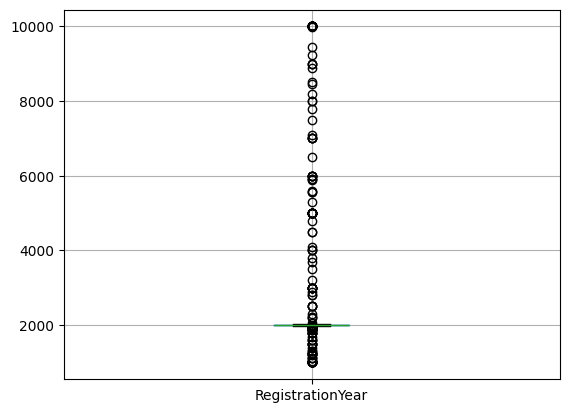

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


Power



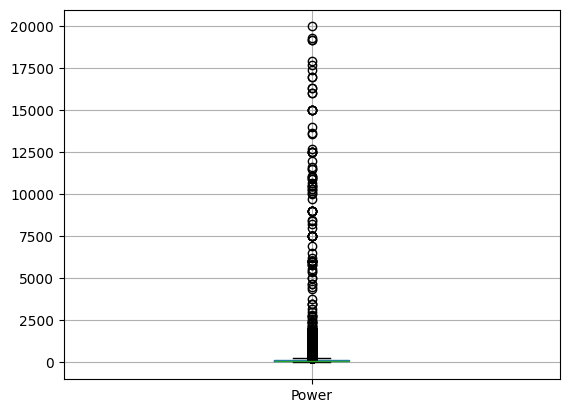

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


Kilometer



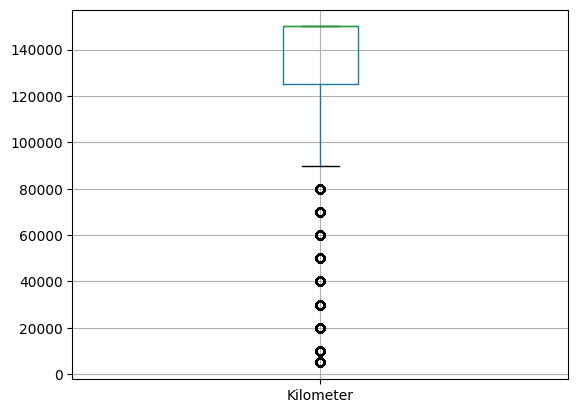

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


In [12]:
# Построим boxplot для трех признаков

column_list_2 = [
    'RegistrationYear',
    'Power', 
    'Kilometer'
]

for i in column_list_2:
    print('\n' + '\n' + '\033[1m' + i + '\033[0m' + '\n')
    df.boxplot(column=i) 
    plt.show()
    print(df[i].describe())

In [13]:
# Уберем неадекватные года регистрации и мощбность

df = df.query('1980 < RegistrationYear < 2022 and 50 < Power < 500')

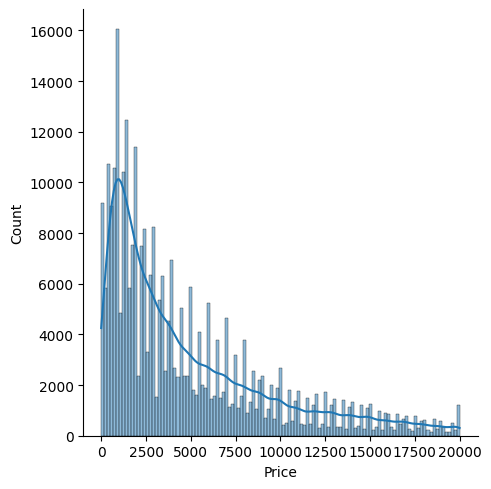

In [14]:
# Построим гистограмму цен

sns.displot(data=df['Price'], kde=True)
plt.show()

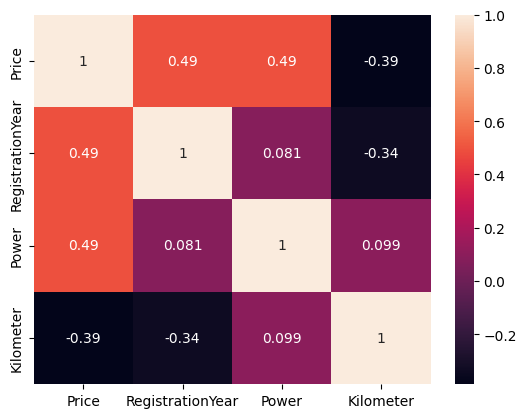

In [15]:
# Посмотрим тепловую карту кореляции числовых признаков от цены

sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

In [16]:
# Сменим тип категориальных признаков на category

categoric_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

df[categoric_list] = df[categoric_list].astype('category')

###  Вывод подготовки данных

1. Удалил 4 дубликата
2. Удалил не нужные для обучения столбцы, относящиеся к заполнению анкеты, но не к самому автомабилю
3. Заменил пропуски на other
4. Ограничил год регистрации авто с 1980-го до 2022-го
5. Ограничил мощность авто с 50 л.с. до 500 л.с.

## Обучение моделей

In [106]:
# Создадим списки для анализа моделей

fit_time = []
pred_time = []
rmse_list = []

### LightGBM

In [18]:
# Разделим данные на тренировочную и валидационную выборку

features_train, features_valid, target_train, target_valid = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.25, random_state=12345
)

In [19]:
# Масштабируем численные признаки

numeric_list = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(df[numeric_list])
features_train[numeric_list] = scaler.transform(features_train[numeric_list])
features_valid[numeric_list] = scaler.transform(features_valid[numeric_list])

In [20]:
# Создадим датасеты для модели LightGBM

train_data = lgb.Dataset(features_train, label=target_train)
test_data = lgb.Dataset(features_valid, label=target_valid, reference=train_data)

In [21]:
# Подготовим параметры для модели LightGBM

params = {
	'objective': 'regression',
	'metric': 'rmse',
	'boosting_type': 'gbdt',
	'num_leaves': 31,
	'learning_rate': 0.05,
	'feature_fraction': 0.9,
}

In [22]:
# Установим количество раундов и обучите модель с ранней остановкой

num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[
				test_data], callbacks=[lgb.early_stopping(stopping_rounds=3),])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 225901, number of used features: 9
[LightGBM] [Info] Start training from score 4795.854914
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1756.61


In [108]:
# Создадим экземпляр LightGBM Regressor с метрикой RMSE
# Обучим модель, используя обучающие данные
# Сделаем прогнозы на основе данных обучения и проверки

model = LGBMRegressor(metric='rmse')

start = time.time()
model.fit(features_train, target_train)
end = time.time()
fit_time.append(end - start)

predict_train = model.predict(features_train)
predict_valid = model.predict(features_valid)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 225901, number of used features: 9
[LightGBM] [Info] Start training from score 4795.854914


In [109]:
# Посчитаем RMSE

print("RMSE тренировочной выборки:", np.sqrt(mse(target_train, predict_train)))
start = time.time()
lgbm_pred = np.sqrt(mse(target_valid, predict_valid))
end = time.time()
print("RMSE валидационной выборки:", lgbm_pred)
pred_time.append(end - start)
rmse_list.append(lgbm_pred)

RMSE тренировочной выборки: 1669.3726627567712
RMSE валидационной выборки: 1715.4307644264297


### LinearRegression

In [59]:
# Создадим 2 списка категориальных признаков

ohe_list = [
    'VehicleType',
    'Model',
    'FuelType',
    'Brand',
]

ohe_list_drop = [
    'Gearbox',
    'Repaired',
]

In [60]:
# Произведем one hot encoding категориальных признаков

data_ohe_train = pd.get_dummies(features_train, columns=ohe_list)
data_ohe_train = pd.get_dummies(data_ohe_train, columns=ohe_list_drop, drop_first=True)

data_ohe_valid = pd.get_dummies(features_valid, columns=ohe_list)
data_ohe_valid = pd.get_dummies(data_ohe_valid, columns=ohe_list_drop, drop_first=True)

In [110]:
# Создадим модель LinearRegression
# Обучим, используя обучающие данные
# Сделаем прогнозы на основе обучающе и валидационной выборки

model = LinearRegression()

start = time.time()
model.fit(data_ohe_train, target_train)
end = time.time()
fit_time.append(end - start)

predict_train = model.predict(data_ohe_train)
predict_valid = model.predict(data_ohe_valid)

In [111]:
# Посчитаем RMSE линейной регрессии

print("RMSE тренировочной выборки:", np.sqrt(mse(target_train, predict_train)))
start = time.time()
linear_pred = np.sqrt(mse(target_valid, predict_valid))
end = time.time()
print("RMSE валидационной выборки:", linear_pred)
pred_time.append(end - start)
rmse_list.append(linear_pred)

RMSE тренировочной выборки: 2550.27788923312
RMSE валидационной выборки: 2535.7880998790174


## Анализ моделей

In [113]:
# Строим таблицу результатов

pd.DataFrame(data=[fit_time, pred_time, rmse_list], columns=['LightGBM','LinearRegression'], 
                          index=['Время обучения', 'Время предсказания', 'RMSE'])

,LightGBM,LinearRegression
Время обучения,0.504631,5.472307
Время предсказания,0.001083,0.001961
RMSE,1715.430764,2535.788100


## Вывод

**Модель градиентного бустинга LightGBM показала результаты лучше чем линейная регрессия по всем заданным критериям. **
* Время обучения в 11 раз быстрее
* Время предсказания почти в 2 раза быстрее
* Ошибка в 1.5 раз меньше

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей